# Squared exponential kernel Gaussian process - PriorCVAE


This is a demo notebook to showcase the usage of PriorCVAE model on a Gaussian process dataset which is generated using a SquaredExponential kernel.

In [1]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp
import flax.linen as nn

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.priors import GP, SquaredExponential
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model
from priorCVAE.datasets import GPDataset
from priorCVAE.trainer import VAETrainer
from priorCVAE.losses import SquaredSumAndKL, MMDAndKL

import jax.config as config
config.update("jax_enable_x64", True)

### Configuration

In [2]:
args = {
        "conditional": True,
        
        # architecture
        "input_dim" : 80,
        "hidden_dim": 60,
        "activation_fn": nn.leaky_relu,
        "latent_dim": 40,
        
        # VAE training    
        "batch_size": 500,
        "num_iterations": 4000,
        "learning_rate": 1e-3,
        "vae_var": 1.,
        "loss": "SquaredSumAndKL",  # [SquaredSumAndKL, MMDAndKL]

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_mcmc_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

### Generate data

We generate the data using an SquaredExponential kernel with lengthscale that is uniformly sampled. We plot a sample from the GP and plot the trajectories and lengthscales.

In [3]:
kernel = SquaredExponential()

gp_data_generator = GPDataset(n_data=args["input_dim"], kernel=kernel, sample_lengthscale=True)  

In [4]:
sample_x_train, sample_y_train, sample_ls_train = gp_data_generator.simulatedata(n_samples=1000)
x_test, y_test, ls_test = gp_data_generator.simulatedata(n_samples=1000)

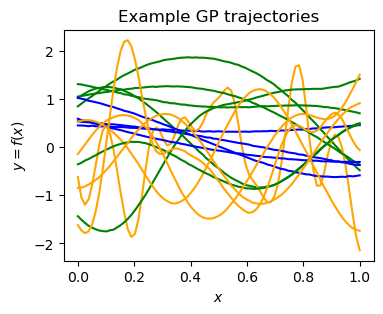

In [5]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if sample_ls_train[i] <= 0.2:
        col = 'orange'
    elif sample_ls_train[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(sample_x_train[i], sample_y_train[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Example GP trajectories')

plt.show()

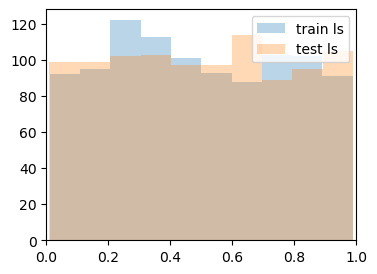

In [6]:
# Plot sample lengthscales
plt.figure(figsize=(4,3))
plt.hist(sample_ls_train[:, 0], alpha = 0.3, label = 'train ls') 
plt.hist(ls_test[:, 0],  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()
plt.show()

### PriorCVAE Model

We define the PriorCVAE model, optimizer, and initialize the parameters of the model randomly.

In [7]:
conditional = args["conditional"]
out_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
activation_fn = args["activation_fn"]
latent_dim = args["latent_dim"]
batch_size = args["batch_size"]
num_iterations  = args["num_iterations"]
true_ls = args["true_ls"]
learning_rate = args["learning_rate"]
vae_var = args["vae_var"]
loss = args["loss"]

In [8]:
encoder = MLPEncoder(hidden_dim, latent_dim, activation_fn)
decoder = MLPDecoder(hidden_dim, out_dim, activation_fn)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)

if loss == "MMDAndKL":
    kernel = SquaredExponential(1.0, 1.0)
    loss = MMDAndKL(kernel, conditional=conditional)
else:
    loss = SquaredSumAndKL(conditional=conditional, vae_var=vae_var)

### Train the model

Train the model and plot the train loss and the test loss.

In [9]:
trainer = VAETrainer(model, optimizer, loss=loss)
trainer.init_params(sample_y_train[0], c=sample_ls_train[0])

test_set = (x_test, y_test, ls_test)
loss_vals, test_vals, time_taken = trainer.train(gp_data_generator, test_set, num_iterations)

print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')

[    1] training loss: 8320.255, test loss: 83386.300
[   11] training loss: 5901.679, test loss: 57912.087
[   21] training loss: 4972.667, test loss: 49506.972
[   31] training loss: 4414.147, test loss: 43352.078
[   41] training loss: 3727.007, test loss: 36685.310
[   51] training loss: 3398.736, test loss: 31584.483
[   61] training loss: 2675.353, test loss: 27910.994
[   71] training loss: 2339.276, test loss: 25843.829
[   81] training loss: 2478.201, test loss: 24066.977
[   91] training loss: 2070.407, test loss: 23200.966
[  101] training loss: 2011.880, test loss: 22088.120
[  111] training loss: 1996.961, test loss: 21547.112
[  121] training loss: 2226.650, test loss: 21041.470
[  131] training loss: 2013.573, test loss: 20281.332
[  141] training loss: 1921.632, test loss: 19949.204
[  151] training loss: 1923.521, test loss: 19345.136
[  161] training loss: 2024.783, test loss: 19410.070
[  171] training loss: 1795.572, test loss: 18990.713
[  181] training loss: 1586.

[ 1541] training loss: 966.874, test loss: 9214.119
[ 1551] training loss: 890.469, test loss: 9250.654
[ 1561] training loss: 877.681, test loss: 9240.467
[ 1571] training loss: 904.915, test loss: 9222.910
[ 1581] training loss: 986.922, test loss: 9226.667
[ 1591] training loss: 943.200, test loss: 9248.065
[ 1601] training loss: 1152.578, test loss: 9129.716
[ 1611] training loss: 753.497, test loss: 9266.793
[ 1621] training loss: 870.095, test loss: 9208.212
[ 1631] training loss: 825.558, test loss: 9286.781
[ 1641] training loss: 1014.359, test loss: 9176.349
[ 1651] training loss: 786.221, test loss: 9142.533
[ 1661] training loss: 918.359, test loss: 9263.619
[ 1671] training loss: 976.264, test loss: 9240.216
[ 1681] training loss: 808.374, test loss: 9155.648
[ 1691] training loss: 974.445, test loss: 9245.944
[ 1701] training loss: 894.475, test loss: 9104.372
[ 1711] training loss: 733.176, test loss: 9157.856
[ 1721] training loss: 886.082, test loss: 9228.910
[ 1731] tr

[ 3121] training loss: 889.037, test loss: 8672.633
[ 3131] training loss: 872.926, test loss: 8636.499
[ 3141] training loss: 829.450, test loss: 8690.420
[ 3151] training loss: 807.065, test loss: 8709.201
[ 3161] training loss: 821.998, test loss: 8726.572
[ 3171] training loss: 836.228, test loss: 8653.450
[ 3181] training loss: 965.810, test loss: 8617.092
[ 3191] training loss: 809.304, test loss: 8646.388
[ 3201] training loss: 800.071, test loss: 8735.458
[ 3211] training loss: 970.016, test loss: 8805.116
[ 3221] training loss: 834.384, test loss: 8664.415
[ 3231] training loss: 888.447, test loss: 8779.811
[ 3241] training loss: 853.551, test loss: 8696.624
[ 3251] training loss: 963.452, test loss: 8687.223
[ 3261] training loss: 1015.030, test loss: 8603.627
[ 3271] training loss: 885.814, test loss: 8675.656
[ 3281] training loss: 758.461, test loss: 8679.267
[ 3291] training loss: 754.160, test loss: 8606.638
[ 3301] training loss: 799.123, test loss: 8686.808
[ 3311] tra

Text(0.5, 1.0, 'Test loss')

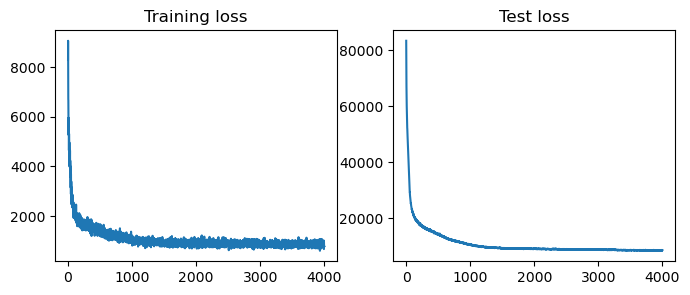

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(range(len(loss_vals)), loss_vals)
axs[0].set_title('Training loss')

axs[1].plot(range(len(test_vals)), test_vals)
axs[1].set_title("Test loss")


### Trained Decoder

We plot a sample of trajectories from the trained decoder model.

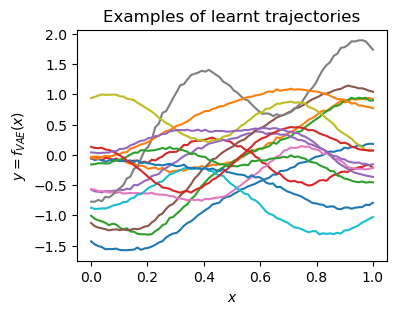

In [11]:
decoder_params = trainer.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (batch_size, latent_dim))

decoder = MLPDecoder(hidden_dim, out_dim, activation_fn)

c = true_ls * jnp.ones((z.shape[0], 1))
z_c = jnp.concatenate([z, c], axis=-1)
out = decoder.apply({'params': decoder_params}, z_c)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

### Inference with MCMC

We randomly generate observations from the GP.

#### Generate data

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

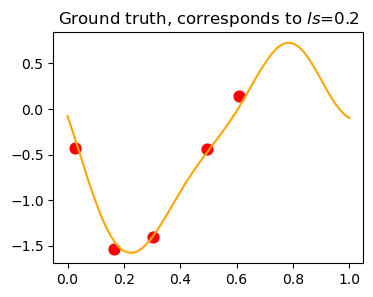

In [12]:
x = sample_x_train[0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=true_ls, variance=1.)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# indices of data points
obs_idx = jnp.array([2, 13, 24, 39, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

### Numpyro model

We define a Nupmyro model to run MCMC.

In [13]:
# add data to args. This is used by MCMC.
args["y_obs"] = y_obs
args["obs_idx"] = obs_idx

In [14]:
c = true_ls * jnp.ones((1, )) if conditional else None

mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, vae_mcmc_inference_model, args, decoder, 
                                                     decoder_params, c=c)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -0.62      0.17     -0.62     -0.90     -0.34  17788.71      1.00
      f[1]     -0.65      0.18     -0.65     -0.94     -0.37  18002.13      1.00
      f[2]     -0.68      0.18     -0.67     -0.97     -0.40  17795.33      1.00
      f[3]     -0.70      0.18     -0.69     -1.00     -0.41  17895.89      1.00
      f[4]     -0.75      0.17     -0.74     -1.03     -0.46  17773.75      1.00
      f[5]     -0.77      0.18     -0.76     -1.05     -0.48  17953.08      1.00
      f[6]     -0.80      0.17     -0.80     -1.08     -0.54  17731.03      1.00
      f[7]     -0.85      0.16     -0.85     -1.11     -0.59  17594.03      1.00
      f[8]     -0.91      0.15     -0.90     -1.17     -0.67  17609.39      1.00
      f[9]     -0.96      0.15     -0.96     -1.20     -0.71  17468.49      1.00
     f[10]     -1.02      0.14     -1.02     -1.25     -0.79  17252.55      1.00
     f[11]     -1.08      0

Average ESS for all VAE-GP effects : 13667


## Plotting

We plot the trajectory after MCMC.

Text(0.5, 1.0, 'PriorCVAE inference')

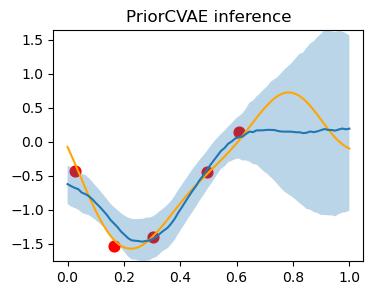

In [15]:
predictive = Predictive(vae_mcmc_inference_model, mcmc_vae_samples)

c = true_ls * jnp.ones((1, )) if conditional else None
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params, c)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

plt.title('PriorCVAE inference')